<a href="https://colab.research.google.com/github/yhyoon06/vandyCS/blob/master/Query5_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Query 5: use rolling window to find correlation values

In [1]:
#install the required packages
!pip3 install influxdb plotly pandas numpy matplotlib

     |████████████████████████████████| 81kB 3.7MB/s 


In [2]:
from influxdb import InfluxDBClient
import json
from datetime import datetime
from getpass import getpass
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pylab import rcParams
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [3]:
covid_client = InfluxDBClient(host='3.85.177.70', username='admin', password='dudgus06', port=8086, database="covid")
forex_client = InfluxDBClient(host='100.25.103.36', username='hunter', password='hcb', port=8086, database="crypto_forex")

In [4]:
# Assuming you have created the energy database through influxd CLI. 
# Now, test the connection status...
print('existing databases for covid data:', covid_client.get_list_database())
print('existing databases for forex data:', forex_client.get_list_database())

existing databases for covid data: [{'name': '_internal'}, {'name': 'covid'}, {'name': 'crypto'}]
existing databases for forex data: [{'name': '_internal'}, {'name': 'crypto_forex'}]


This is a test run to see the correlation between US daily new covid cases and EURUSD closing price

In [152]:
country = 'USA'
pairs = ['C:EURUSD', 'C:GBPUSD', 'C:JPYUSD', 'C:CNYUSD', 'X:BTCUSD']

def daily_new(country):
  query_str = 'SELECT mean("daily_new_cases") AS "mean" FROM covid WHERE time > \'2020-02-14T00:00:00Z\' AND time < \'2021-04-01T00:00:00Z\' AND "country"=\'{}\' GROUP BY time(7d) FILL(null)'.format(country)
  
  try:
    result = pd.DataFrame(covid_client.query(query_str).get_points('covid'))
  except Exception as e:
    print(e)

  return result

continent = 'Europe'
def daily_new2(continent):
  query_str = 'SELECT sum("daily_new_cases") AS "sum" FROM covid WHERE time > \'2020-02-14T00:00:00Z\' AND time < \'2021-04-01T00:00:00Z\' AND "continent"=\'{}\' GROUP BY time(7d) FILL(null)'.format(continent)
  
  try:
    result = pd.DataFrame(covid_client.query(query_str).get_points('covid'))
  except Exception as e:
    print(e)

  return result

def mean_close(pair):
    query_str='SELECT mean("c") AS "mean" FROM crypto_forex WHERE time > \'2020-02-14T00:00:00Z\' AND time < \'2021-04-01T00:00:00Z\' AND "pair"=\'{}\' GROUP BY time(7d) FILL(null)'.format(pair)
    
    try:
      result = pd.DataFrame(forex_client.query(query_str).get_points('crypto_forex'))
    except Exception as e:
      print(e)

    return result

covid_result = daily_new(country)
covid_result2 = daily_new2(continent)
curr_results = [mean_close(pair) for pair in pairs]

In [153]:
covid_result2.head(3)

,time,sum
0,2020-02-13T00:00:00Z,0.0
1,2020-02-20T00:00:00Z,0.0
2,2020-02-27T00:00:00Z,0.0


In [145]:
curr_results[0].head(3)

,time,mean
0,2020-02-13T00:00:00Z,1.082154
1,2020-02-20T00:00:00Z,1.084170
2,2020-02-27T00:00:00Z,1.108014


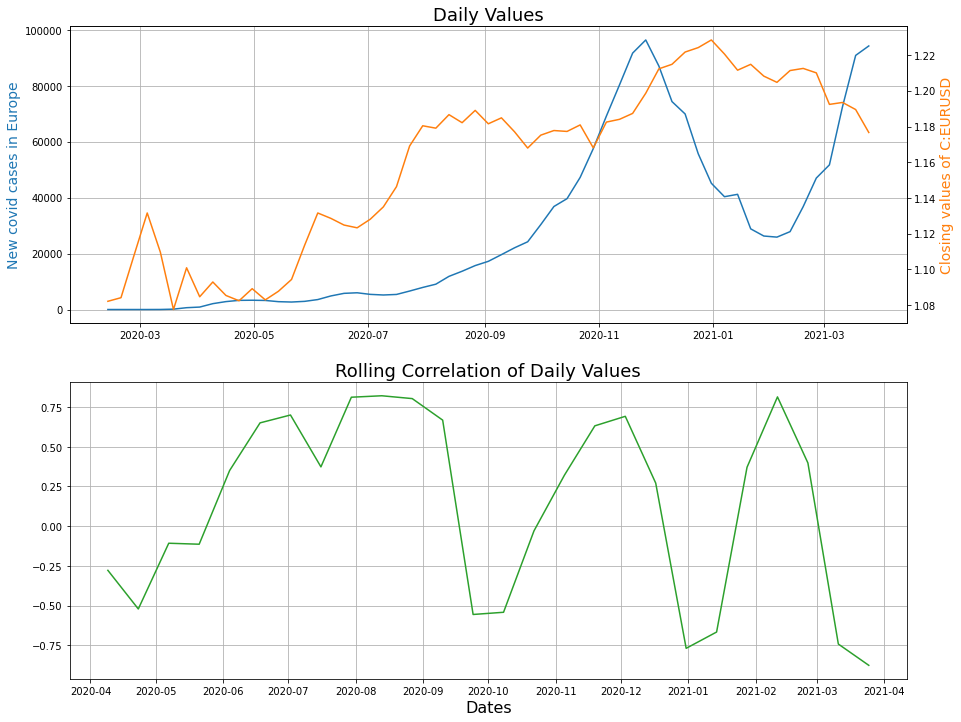

In [157]:
def monthly_ticks(axs, i, x, y, c, t):
  axs[i].plot(x, y, color = c)
  axs[i].set_title(t, fontsize = 18)

  fmt_month = mdates.MonthLocator(interval=1)
  axs[i].xaxis.set_major_locator(fmt_month)

  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  axs[i].format_xdata = mdates.DateFormatter('%Y-%m')
  axs[i].grid(True)

def plot_rolling(country, currency, covid_result, curr_result):
  titles = ['Daily Values', 'Rolling Correlation of Daily Values']

  fig, axs = plt.subplots(2, figsize=(15, 12))
  timesteps = [datetime.strptime(r[:10], '%Y-%m-%d') for r in covid_result['time']]
  monthly_ticks(axs, 0, timesteps, covid_result["sum"], '#1f77b4', titles[0])

  ax2 = axs[0].twinx()
  ax2.plot(timesteps, curr_result["mean"], color = '#ff7f0e')
  axs[0].set_ylabel('New covid cases in {}'.format(country), color='#1f77b4', fontsize = 14)
  ax2.set_ylabel('Closing values of {}'.format(currency), color='#ff7f0e', fontsize = 14)

  rolling_corr = covid_result['sum'].rolling(8).corr(curr_result['mean'])[::2]
  rolling_timesteps = timesteps[::2]
  monthly_ticks(axs, 1, rolling_timesteps, rolling_corr, '#2ca02c', titles[1])
  axs[1].set_xlabel("Dates", fontsize = 16)

  #plt.tight_layout()
  #plt.show()
  plt.savefig("rollingCorr_Europe_{}.png".format(currency))

#for i in range(len(pairs)):
plot_rolling(continent, pairs[0], covid_result2, curr_results[0])

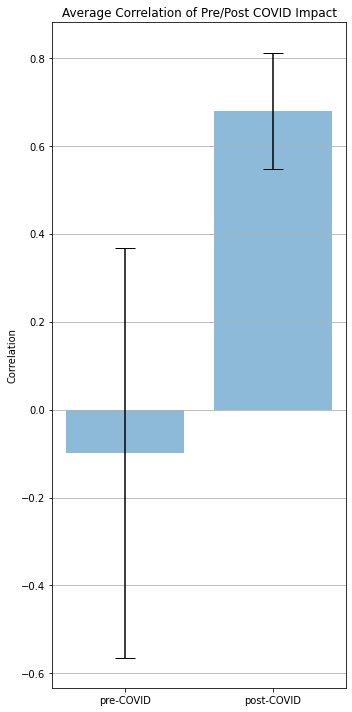

In [127]:
from scipy import stats

idx = [i for i, j in enumerate(rolling_corr) if j >= 0.5]
precovid = rolling_corr[:20]
postcovid = rolling_corr[20:]

labels = ['pre-COVID', 'post-COVID']
x_pos = np.arange(len(labels))
bars = [np.mean(precovid), np.mean(postcovid)]
error = [np.std(precovid), np.std(postcovid)]

fig, ax = plt.subplots(figsize=(5, 10))
ax.bar(x_pos, bars, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Correlation')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Average Correlation of Pre/Post COVID Impact')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()


In [130]:
print(rolling_timesteps[20])

2020-11-19 00:00:00


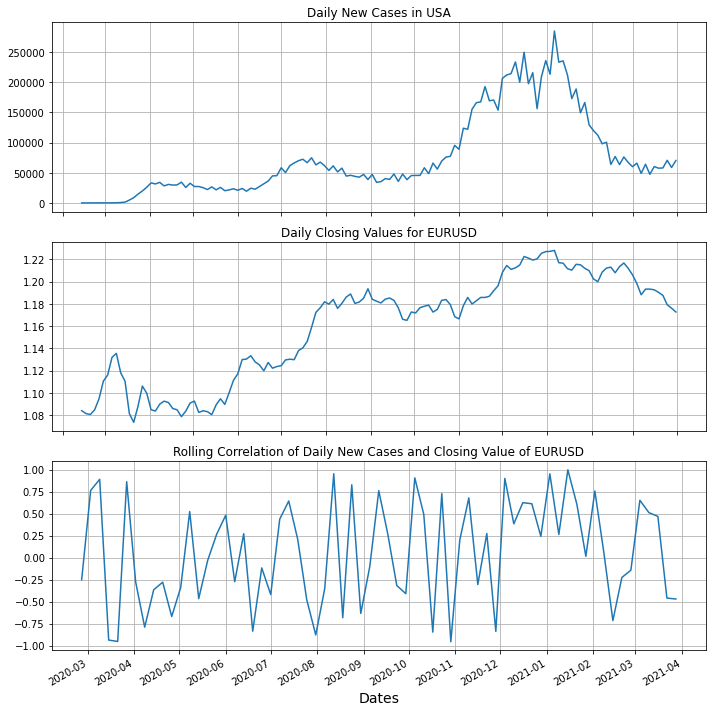

In [48]:
def monthly_ticks(axs, i, x, y, t):
  axs[i].plot(x, y)
  axs[i].set_title(t)

  fmt_month = mdates.MonthLocator(interval=1)
  axs[i].xaxis.set_major_locator(fmt_month)

  axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

  axs[i].format_xdata = mdates.DateFormatter('%Y-%m')
  axs[i].grid(True)

result = [covid_result, forex_result]
#values = ['daily_new_cases', 'mean_c']
titles = ['Daily New Cases in USA', 'Daily Closing Values for EURUSD']

fig, axs = plt.subplots(3, figsize=(10,10))

for i in range(len(result)):

  timesteps = [datetime.strptime(r[:10], '%Y-%m-%d') for r in result[i]['time']]
  daily = [r for r in result[i]["mean"]]

  monthly_ticks(axs, i, timesteps, daily, titles[i])

rolling_corr = covid_result['mean'].rolling(4).corr(forex_result['mean'])[::2]
rolling_timesteps = timesteps[::2]
monthly_ticks(axs, 2, rolling_timesteps, rolling_corr, "Rolling Correlation of Daily New Cases and Closing Value of EURUSD")

fig.autofmt_xdate()
plt.xlabel("Dates", fontsize = 14)
plt.tight_layout()
#plt.savefig("rollingcorr_test.png")